# 🧩 OFDM Fundamentals

--> **Author:** Rahul Gulia  
--> **Ph.D. Student**  
--> **Rochester Institute of Technology**


## Key Points:

1. Multi-carrier modulation: OFDM divides a high-rate data stream into multiple low-rate substreams distributed over orthogonal carriers.
2. Orthogonal signals: In OFDM, sub-carriers are spaced at intervals delta_f = 1/T, where T is the symbol duration

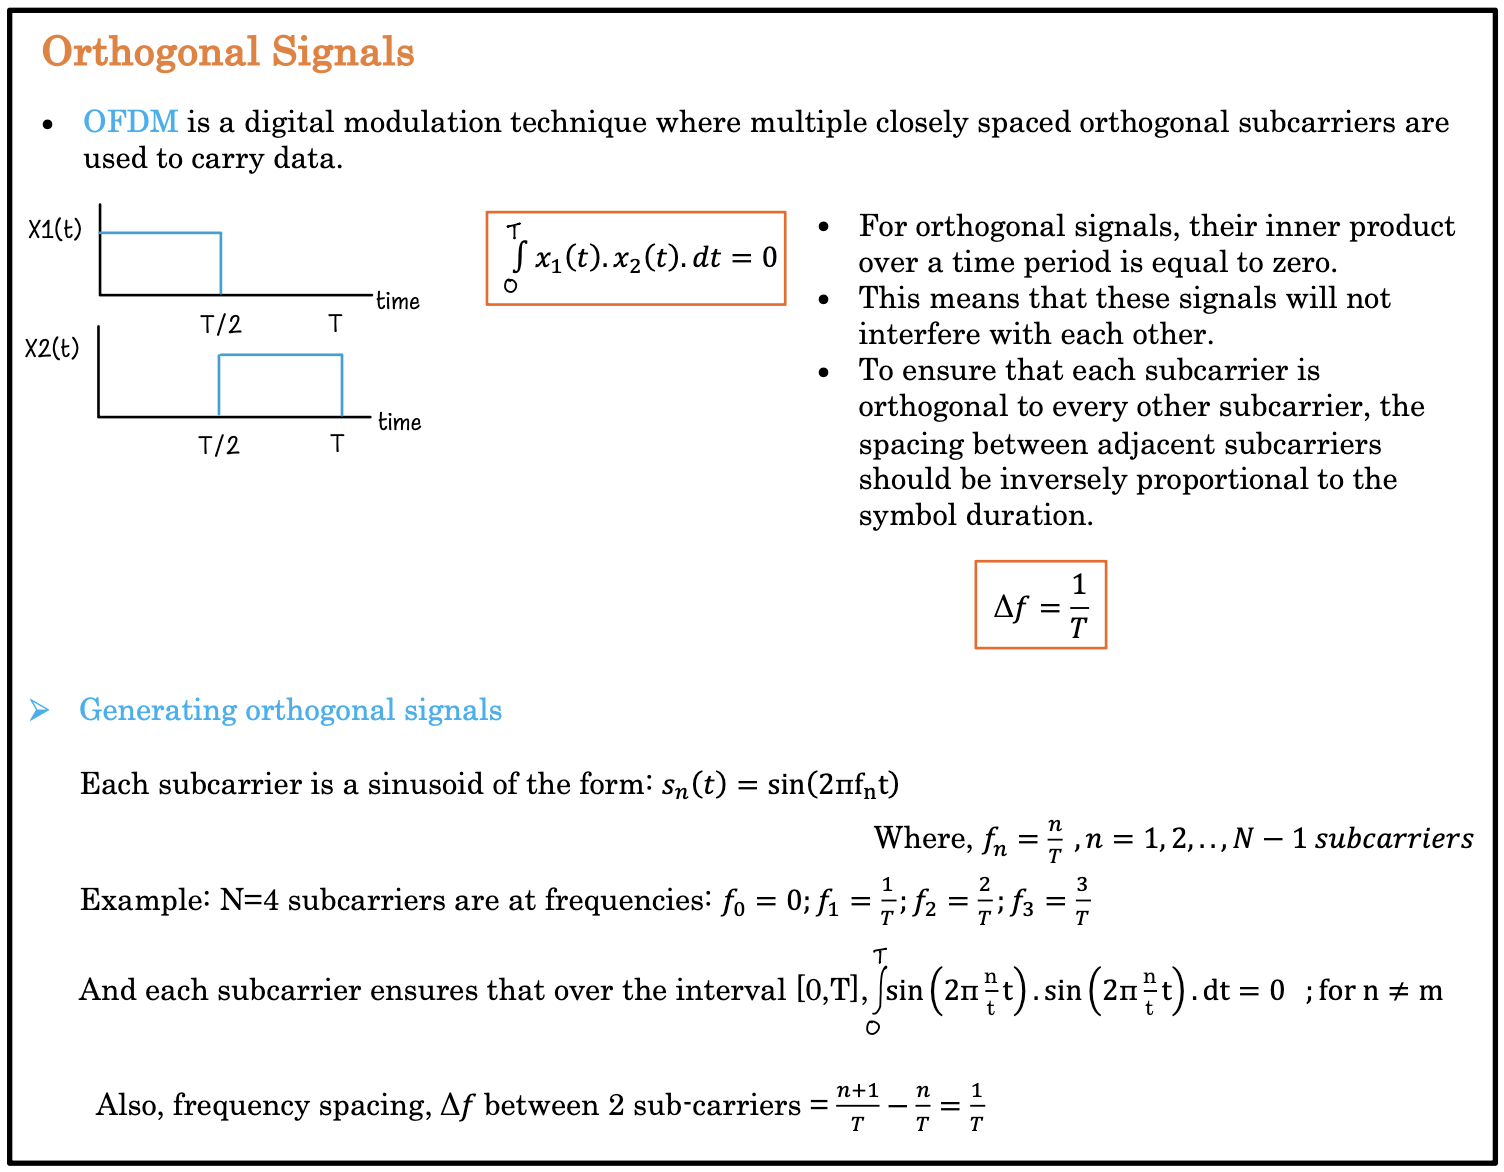

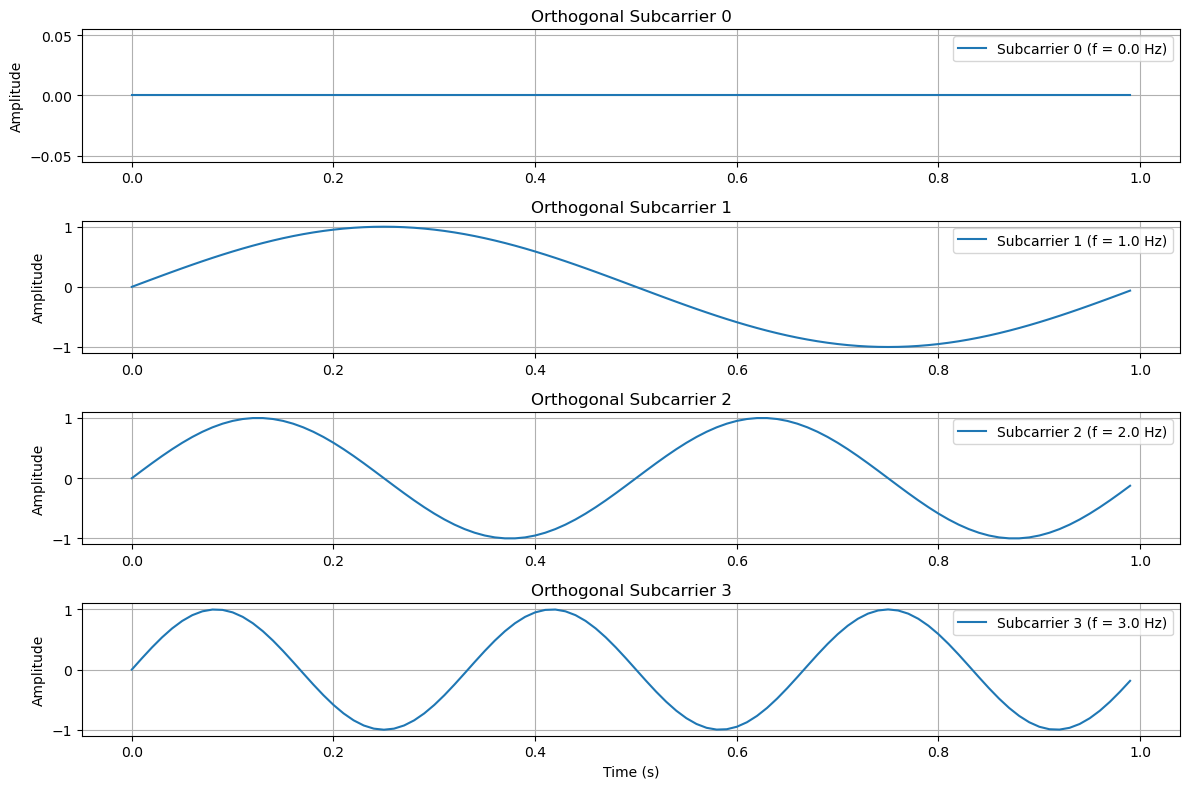

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # symbol duration (seconds)
N = 4  # number of subcarriers
fs = 100  # sampling frequency
t = np.linspace(0, T, int(T * fs), endpoint=False)

# Generate orthogonal subcarriers
subcarriers = [np.sin(2 * np.pi * n / T * t) for n in range(N)]

# Plot the subcarriers
plt.figure(figsize=(12, 8))
for i, carrier in enumerate(subcarriers):
    plt.subplot(N, 1, i + 1)
    plt.plot(t, carrier, label=f'Subcarrier {i} (f = {i/T:.1f} Hz)')
    plt.title(f'Orthogonal Subcarrier {i}')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


* After learning about the orthogonal signals, lets dive into OFDM 

# OFDM: Transmitting random bits

SNR:  0 dB | BER: 3.653e-01 | ✗
SNR:  2 dB | BER: 3.281e-01 | ✗
SNR:  4 dB | BER: 2.950e-01 | ✗
SNR:  6 dB | BER: 2.536e-01 | ✗
SNR:  8 dB | BER: 2.180e-01 | ✗
SNR: 10 dB | BER: 1.831e-01 | ✗
SNR: 12 dB | BER: 1.677e-01 | ✗
SNR: 14 dB | BER: 1.417e-01 | ✗
SNR: 16 dB | BER: 1.318e-01 | ✗
SNR: 18 dB | BER: 1.219e-01 | ✗
SNR: 20 dB | BER: 1.135e-01 | ✗
SNR: 22 dB | BER: 1.132e-01 | ✗
SNR: 24 dB | BER: 1.106e-01 | ✗
SNR: 26 dB | BER: 1.099e-01 | ✗
SNR: 28 dB | BER: 1.097e-01 | ✗
SNR: 30 dB | BER: 1.081e-01 | ✗
SNR: 32 dB | BER: 1.080e-01 | ✗
SNR: 34 dB | BER: 1.075e-01 | ✗
SNR: 36 dB | BER: 1.062e-01 | ✗
SNR: 38 dB | BER: 1.063e-01 | ✗
SNR: 40 dB | BER: 1.071e-01 | ✗
SNR: 42 dB | BER: 1.065e-01 | ✗
SNR: 44 dB | BER: 1.069e-01 | ✗
SNR: 46 dB | BER: 1.065e-01 | ✗
SNR: 48 dB | BER: 1.066e-01 | ✗


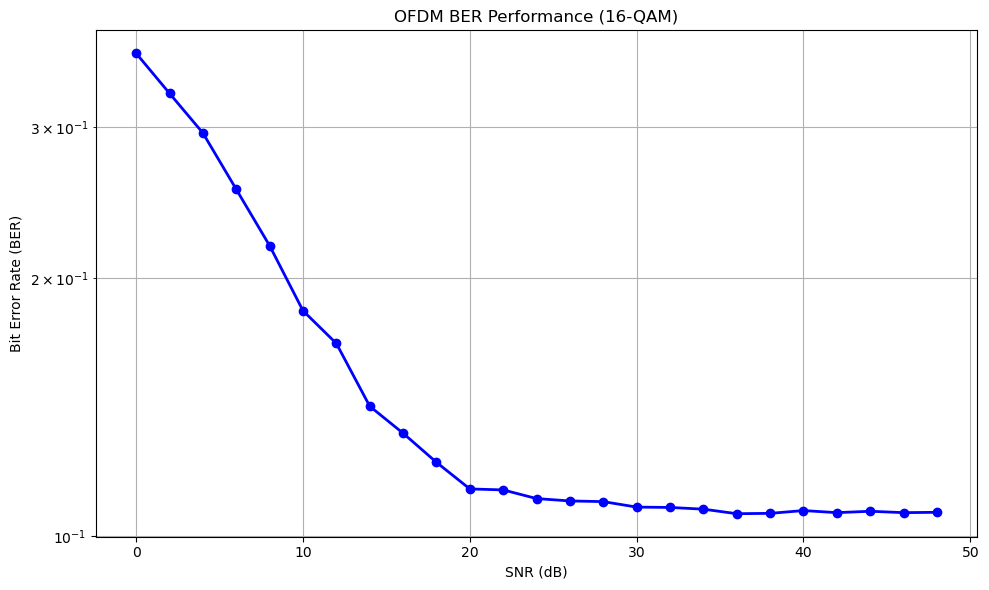

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def ofdm_simulation():
    # Simulation parameters
    num_bits = 10000
    mod_scheme = '16-QAM'
    N = 64                  # Number of subcarriers
    CP = 16                 # Cyclic prefix length
    pilot_positions = [0, 16, 32, 48]
    snr_db_values = np.arange(0, 50, 2)  # Reasonable SNR range

    # Modulation config
    config = {
        'QPSK': {
            'bits': 2,
            'symbols': np.array([1+1j, -1+1j, -1-1j, 1-1j]) / np.sqrt(2)
        },
        '16-QAM': {
            'bits': 4,
            'symbols': np.array([
                -3-3j, -3-1j, -3+3j, -3+1j,
                -1-3j, -1-1j, -1+3j, -1+1j,
                 3-3j,  3-1j,  3+3j,  3+1j,
                 1-3j,  1-1j,  1+3j,  1+1j
            ]) / np.sqrt(10)  # Normalize average power to 1
        }
    }
    cfg = config[mod_scheme]

    # Generate random bitstream (ensure it's a multiple of bits per symbol)
    tx_bits = np.random.randint(0, 2, num_bits)
    extra_bits = len(tx_bits) % cfg['bits']
    if extra_bits != 0:
        tx_bits = tx_bits[:-extra_bits]

    # Map bits to symbols
    reshaped_bits = tx_bits.reshape(-1, cfg['bits'])
    symbol_indices = np.array([int("".join(str(b) for b in row), 2) for row in reshaped_bits])
    tx_symbols = cfg['symbols'][symbol_indices]

    ber_results = []

    for snr_db in snr_db_values:
        # Padding symbols to fill complete OFDM blocks
        symbols = np.copy(tx_symbols)
        if len(symbols) % N != 0:
            pad = N - len(symbols) % N
            symbols = np.concatenate([symbols, np.zeros(pad, dtype=complex)])

        ofdm_blocks = symbols.reshape(-1, N)

        # Insert pilots
        pilot_symbol = 1 + 1j
        ofdm_blocks[:, pilot_positions] = pilot_symbol

        # IFFT and add Cyclic Prefix
        time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
        time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
        tx_signal = time_blocks_cp.flatten()

        # Channel (multipath + AWGN)
        channel_taps = np.array([1.0, 0.0, 0.3])
        channel_taps = channel_taps / np.linalg.norm(channel_taps)  # Normalize energy
        rx_signal = np.convolve(tx_signal, channel_taps, mode='same')  # Apply multipath
        signal_power = np.mean(np.abs(rx_signal)**2)
        noise_power = signal_power / (10**(snr_db/10))
        noise = np.sqrt(noise_power/2) * (np.random.randn(len(rx_signal)) + 1j*np.random.randn(len(rx_signal)))
        rx_signal += noise  # Add AWGN *after* channel

        # Receiver: Reshape & Remove CP
        rx_blocks = rx_signal.reshape(-1, N + CP)
        rx_blocks = rx_blocks[:, CP:]  # Remove CP
        rx_symbols_blocks = np.fft.fft(rx_blocks, axis=1)

        # Channel Estimation (pilot-based)
        H_est = np.ones_like(rx_symbols_blocks)
        for pos in pilot_positions:
            H_est[:, pos] = rx_symbols_blocks[:, pos] / pilot_symbol

        # Interpolate channel response across all subcarriers
        x = np.arange(N)
        for i in range(H_est.shape[0]):
            H_real = interpolate.interp1d(pilot_positions, H_est[i, pilot_positions].real, kind='linear', fill_value="extrapolate")(x)
            H_imag = interpolate.interp1d(pilot_positions, H_est[i, pilot_positions].imag, kind='linear', fill_value="extrapolate")(x)
            H_est[i] = H_real + 1j * H_imag

        # Equalize
        rx_eq = rx_symbols_blocks / H_est
        rx_eq = rx_eq.flatten()[:len(tx_symbols)]  # Trim padding

        # Symbol Detection
        distances = np.abs(rx_eq[:, None] - cfg['symbols'][None, :])
        detected_indices = np.argmin(distances, axis=1)

        # Convert symbol indices back to bits
        rx_bits = np.array([np.binary_repr(i, width=cfg['bits']) for i in detected_indices])
        rx_bits = np.array([list(map(int, b)) for b in rx_bits]).flatten()

        # Compute BER
        min_len = min(len(tx_bits), len(rx_bits))
        ber = np.mean(tx_bits[:min_len] != rx_bits[:min_len])
        ber_results.append(ber)
        print(f"SNR: {snr_db:2d} dB | BER: {ber:.3e} | {'✓' if ber < 0.1 else '✗'}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(snr_db_values, ber_results, 'bo-', linewidth=2, markersize=6)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title(f'OFDM BER Performance ({mod_scheme})')
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()

ofdm_simulation()
